In [50]:
import time
import copy
import os, sys
import os.path
join = os.path.join
import numpy as np
import pandas as pd
import stats
import json
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as heirarchy
from tabulate import tabulate
from scipy.spatial.distance import pdist
import SALib.analyze as sal
#
import rtw
import _fj
import txtdata
import fjanalysis
import sobol
import twutils
import twanalyse
import plotutils

from IPython.display import display, HTML
print(sal.__file__)


/home/dan/usb_twitching/pili/notebook/SALib/analyze/__init__.py


In [51]:
verbose = False


In [52]:
# we pulled analysis data (local.json) back from the cluster using compute-sync.sh script
notedir, notename = os.path.split(os.getcwd())
notename, _ = os.path.splitext(notename)
if not os.path.exists(notename):
    print('new data directory at ', os.path.abspath(notename))
    os.mkdir(notename)

simdir = "/home/dan/usb_twitching/run/b2392cf/cluster/sobol_01"
second_order = True
# simdir = "/home/dan/usb_twitching/run/b2392cf/cluster/sobol_ssense"
# second_order = False
with open(join(simdir, "lookup.json"), 'r') as f:
    lookup = json.load(f)
problem = sobol.read_problem(simdir)
print(problem)


{'num_vars': 6, 'names': ['k_ext_off', 'dwell_time', 'pilivar', 'anchor_angle_smoothing_fraction', 'k_spawn', 'k_resample'], 'bounds': [[0.2, 1.0], [0.5, 3.0], [1.0, 20.0], [0.125, 1.0], [0.5, 5.0], [1.0, 10.0]]}


In [53]:
# first job is to check that the simulation and analysis actually ran
stats_mask = np.array([os.path.exists(join(simdir, udir, "local.json")) for udir in lookup[0]])
num, denom = np.count_nonzero(stats_mask), len(lookup[0])
print('ran samples {}/{} ({:.1f}%)'.format(num, denom, 100*float(num)/denom))


ran samples 14336/14336 (100.0%)


In [54]:
objectives = ['lvel.mean', 'deviation.var', 'qhat.estimate', 'ahat.estimate', 'nbound.mean']
objectives.append('bound_pili_participation')
Y, lduid = sobol.collect(objectives, targetdir=simdir, alldata=True)
Ynbound = Y["nbound.mean"]
print("gathered all data")


gathered all data


In [55]:

# check for missing data
def check_missing(lookup, Y):
    missing_table = []
    for name in Y.keys():
        nans = np.isnan(Y[name])
        missing_table.append([name, np.count_nonzero(nans)])
        if np.any(nans):
            # find first 'failed' analysis
            nanid = np.argwhere(nans)[0][0]
            nanuid = lookup[0][nanid]
    print(tabulate(missing_table, headers=["objective", "nan data"]))
check_missing(lookup, Y)

# no nan data

objective                   nan data
------------------------  ----------
lvel.mean                          0
deviation.var                      0
qhat.estimate                      0
ahat.estimate                      0
nbound.mean                        0
bound_pili_participation           0


In [56]:

Si = {}
for name in Y.keys():
    Si[name] = sal.sobol.analyze(problem, Y[name], 
        calc_second_order=second_order)


In [57]:
"""
reduced_names = [
    'k_ext_off', 
    'dwell_time',
    'pilivar', 
    'anchor_angle_smoothing_fraction',
    'k_spawn', 
    'k_resample',
]
 
reduced_problem = {
    'num_vars': 6,
    'names': reduced_names,
    'bounds': [
        [1.0,5.0],
        [0.5,3.0],
        [1.0,20.0],
        [0.125,1.0],
        [0.5,5.0],
        [1.0,10.0]
    ]
}

['lvel.mean', 'deviation.var', 'qhat.estimate', 'ahat.estimate']
"""


# Si['lvel.mean']
# varname = 'deviation.var'
def tabulate_Si(Si, objectives):
    S1table = []
    STtable = []
    for varname in objectives:
        S = Si[varname]
        S1table.append(list(S['S1']))
        STtable.append(list(S['ST']))
    _table1 = list(zip(problem['names'], *S1table))
    _table2 = list(zip(problem['names'], *STtable))
    header = ["parameter"] + objectives
    table1 = tabulate(_table1, headers=header, floatfmt='.4f')
    table2 = tabulate(_table2, headers=header, floatfmt='.4f')
    # tableT = tabulate(STtable, headers=header_T)
    print("First order sensitivity indices")
    print(table1)
    print()
    print("\"total\" sensitivity indices")
    print(table2)
tabulate_Si(Si, objectives)

# TODO
# check convergence by running 10x larger


First order sensitivity indices
parameter                          lvel.mean    deviation.var    qhat.estimate    ahat.estimate    nbound.mean    bound_pili_participation
-------------------------------  -----------  ---------------  ---------------  ---------------  -------------  --------------------------
k_ext_off                             0.2381           0.0106           0.1162           0.0039         0.2596                      0.8930
dwell_time                            0.0414           0.0482           0.0386           0.0094         0.2341                      0.0004
pilivar                              -0.0008           0.7353           0.1608           0.0381         0.0179                      0.0776
anchor_angle_smoothing_fraction       0.2609           0.0720           0.4321           0.8903         0.0017                      0.0038
k_spawn                               0.3523           0.0407           0.0355           0.0045         0.3038                      0.

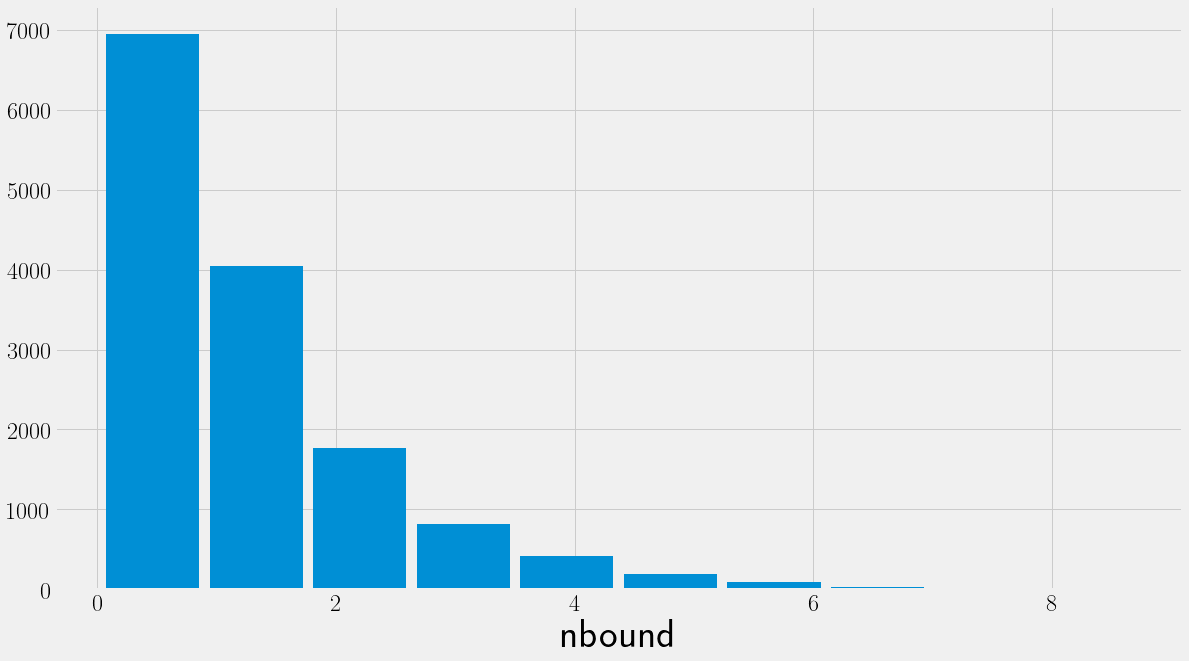

[0.1506  0.14775 0.18205 ... 0.95235 3.0113  2.98345]
nbound nan count 0


In [58]:
# -------------------------------
# analyse nbound and average velocity globally and set limits
# if the cell moved by less than 10 steps we exit the analysis early
xuid = np.array(lookup[0])

# construct the whole nbound array with nans where necessary

nbound = np.empty(len(lookup[0]))
for i ,uid in enumerate(lookup[0]):
    try:
        nb = lduid[uid]['nbound']['mean'] 
        nbound[i] = nb
    except KeyError:
        nbound[i] = np.nan

plt.hist(nbound, rwidth=0.9)
plt.xlabel("nbound")
plt.show()

print(nbound)
print('nbound nan count', np.count_nonzero(np.isnan(nbound)))


In [59]:
# loading
all_idx, ltrs = _fj.slicehelper.load_linearized_trs("all")

100%|██████████| 3113/3113 [00:01<00:00, 2558.39it/s]


In [60]:
# first of all what are the summary statistics for fanjin subsets
# objectives must be observables
objectives = ['lvel.mean', 'deviation.var', 'qhat.estimate', 'ahat.estimate']
getter = [twutils.make_get(name) for name in objectives]

# load candidate data
candidate_track = _fj.lintrackload([2924])[0]
ld = fjanalysis.lsummary([candidate_track])

reference_idx = _fj.load_subset_idx()
subsets =  list(reference_idx.keys())
df = fjanalysis.compute_reference_data(ltrs, reference_idx, objectives)

# rows = [[subset]+[refdata[subset][name] for name in objectives] 
#     for subset in refdata.keys()]
# table = tabulate(rows, headers=['-'] + objectives)
# print(table)

def df_write_latex(df, path):
    print("writing latex table to ", path)
    with open(path, 'w') as f:
        f.write(df.to_latex())
df_write_latex(df, "/home/dan/usb_twitching/notes/sensitivity/tex/fanjinstats.tex")
df


# use dataframe to make table
# ...

100%|██████████| 1/1 [00:00<00:00, 4060.31it/s]
/home/dan/usb_twitching/pili/src/analysis/twanalyse.py:934: RuntimeWarning: invalid value encountered in true_divide
  norm_dy = dy/np.linalg.norm(dy, axis=1)[:,np.newaxis]


writing latex table to  /home/dan/usb_twitching/notes/sensitivity/tex/fanjinstats.tex


,subset,lvel.mean,deviation.var,qhat.estimate,ahat.estimate
0,candidate,0.173882,0.340840,0.752234,0.126103
1,top,0.072232,0.708642,0.470209,0.165958
2,half,0.036487,1.044969,0.447158,0.092109
3,median,0.015663,1.599534,0.263178,0.073962
4,walking,0.173724,2.652627,0.118843,0.731995


In [61]:
# a separate table for the sobol analysis of similarity measures
from sobol import collect_obs, compute_sobol, format_sobol

# fanjin.<subset>.chi
scores = ['fanjin.%s.chi' % subset for subset in reference_idx.keys()]
subnames = list(reference_idx.keys())
second_order = True

sty = {"floatfmt": ' .3f', 'headers':'keys'}
Yf = collect_obs(lookup, lduid, subnames, scores)
Sf = compute_sobol(problem, Yf)
dftable1, dftableT = format_sobol(problem, Sf)

print("chi metric sobol index")
print(tabulate(dftable1, **sty))
print()
print(tabulate(dftableT, **sty))

df_write_latex(dftableT, "/home/dan/usb_twitching/notes/sensitivity/tex/vel_similarity.tex")

# which proves our observation that the anchor flexibility 
# changes the velocity distribution shape more than any other parameter
# Note 1st order sobol indices do not sum to 1.
# may need to check convergence


chi metric sobol index
    parameter                          candidate     top    half    median    walking
--  -------------------------------  -----------  ------  ------  --------  ---------
 0  k_ext_off                              0.005  -0.007   0.013     0.021      0.003
 1  dwell_time                             0.039   0.012   0.003     0.005      0.009
 2  pilivar                               -0.005   0.007   0.028     0.063      0.035
 3  anchor_angle_smoothing_fraction        0.726   0.787   0.646     0.635      0.882
 4  k_spawn                               -0.004   0.001   0.005     0.010      0.002
 5  k_resample                             0.006   0.000   0.015     0.026      0.008

    parameter                          candidate     top    half    median    walking
--  -------------------------------  -----------  ------  ------  --------  ---------
 0  k_ext_off                              0.106   0.071   0.123     0.126      0.022
 1  dwell_time                

In [62]:
if verbose:
    scores = ['fanjin.%s.ks_statistic' % subset for subset in subnames]
    ks_Yf = collect_obs(lookup, lduid, subnames, scores)
    ks_Sf = compute_sobol(problem,  ks_Yf)
    dftable1, dftableT = format_sobol(problem, ks_Sf)

    print("ks metric sobol index")
    print(tabulate(dftable1, **sty))
    print()
    print(tabulate(dftableT, **sty))



In [63]:
# 
# simdir = "/home/dan/usb_twitching/run/b2392cf/cluster/sobol_ssence"
# with open(join(simdir, "lookup.json"), 'r') as f:
#     lookup = json.load(f)
# problem = sobol.read_problem(simdir)
# print(problem)



In [64]:

# qap = [twanalyse._qaparams([ltr]) for ltr in reftrs["top"]]
# nsteps = np.array([ltr.get_nsteps() for ltr in reftrs["top"]])
# duration = np.array([ltr.get_duration() for ltr in reftrs["top"]])
# q = np.array([ld['qhat']['estimate'] for ld in qap])
# a = np.array([ld['ahat']['estimate'] for ld in qap])
# plt.hist(nsteps*q)
# np.sum(duration * q)/np.sum(duration)



In [65]:

# OLD 
# maybe useful to check against

Ycandidate = {name : getter[i](ld) for i,name in enumerate(objectives)}
# #
# # load crawling whitelist
# whitelist, whitelist_tracks = _fj.slicehelper.load_linearized_trs("candidates_whitelist")
# white_data = {}
# ldata = [fjanalysis.lsummary([track]) for track in whitelist_tracks]
# for i, name in enumerate(objectives):
#     # no weighting
#     white_data[name] = np.mean([getter[i](ld) for ld in ldata])
# white_data
# nstep = np.array([len(tr.step_idx)-1 for tr in whitelist_tracks])
# q = np.array([ld["qhat"]["estimate"] for ld in ldata])
# np.sum(nstep * q)/np.sum(nstep)



In [66]:
tmp = False
# IMPORTANT understand why persistence does this!
# large negative values are contributing to the sum?
# why does that not matter for per track persistence?

if tmp:
    step_vel = [ltr.get_step_velocity() for ltr in whitelist_tracks]
    sim_ut = []
    sim_up = []
    for svel in step_vel:
        sim_ut.append(svel[1:])
        sim_up.append(svel[:-1])
    u_t = np.concatenate(sim_ut, axis=0)
    u_p = np.concatenate(sim_up, axis=0)
    #
    _sample = np.array(range(u_t.shape[0]))
    N = 100
    _split_at = np.array(range(N, _sample.shape[0], N))
    #
    qs = []
    for window in np.split(_sample, _split_at)[:-1]:
        sample = np.array(window)
        print(sample)
        qhat = np.sum( (u_t*u_p).sum(axis=1)[sample] )/np.sum( (u_p*u_p).sum(axis=1)[sample])
        qs.append(qhat)
    np.mean(qs)

    # TODO
    # CHECK simulated data with multiple tracks to see if the peristence calculation is robust


 since  we are having trouble with sobol, lets shift gear and attempt to answer the question
 of how close we get to candidate trajectory in each objective function and in all objectives
 simultaneously
 To get some geometric intuition we could start by
 1. scatter plots of <nbound> against [objective]

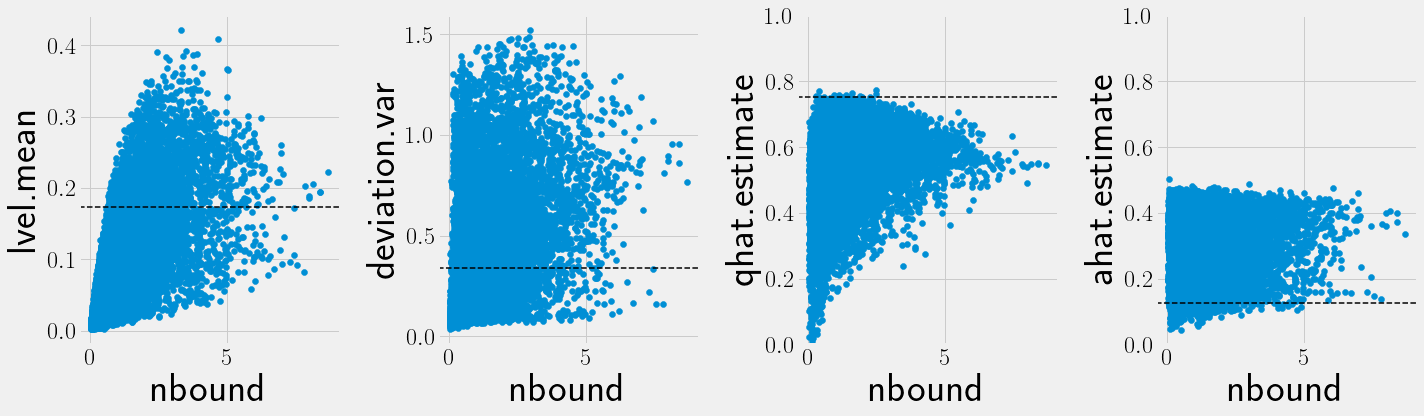

In [67]:

# scatter plot bounds
fbounds = [
    (None,None),
    (None,None),
    (0,1.0),
    (0,1.0)
]
def plot_nbound_scatter(xbasis, Y,  objectives, fbounds, 
        refdata=Ycandidate, color=None):
    Nx = len(objectives)
    hstyle = {"color":"k", "linestyle":"--"}
    fig, axes = plt.subplots(1,Nx,figsize=(Nx*5,6))
    for i, name in enumerate(objectives):
        A, B = xbasis, Y[name]
        ax = axes[i]
        if not color is None:
            ax.scatter(A,B, c=color)
        else:
            ax.scatter(A,B)
        ax.set_ylabel(name)
        ax.set_xlabel("nbound")
        ax.axhline(refdata[objectives[i]], **hstyle)
        by = fbounds[i]
        ax.set_ylim(by)
    return fig, axes

plot_nbound_scatter(Ynbound, Y, objectives, fbounds)

plt.tight_layout()

total_bounds = copy.deepcopy(fbounds)
def get_lims(arr):
    return np.nanmin(arr), np.nanmax(arr)
total_bounds[0] = get_lims(Y[objectives[0]])
total_bounds[1] = get_lims(Y[objectives[1]])


 pareto set excludes huge range of deviation.var objective indicating that
 simulations for which this cost function is large perform worse in each of the other
 three studied criteria simultaneously.

 we include the candidate values in all 4 metrics which means the next question is what is the closest
 parameter set we can get to all the objectives simultaneously
 clearly we need a way to make this problem well defined, e.g.
 * combined metric
 * pareto optimisation

<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-68-cd8b7664cf6e>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if subset is "walking":


pareto sets 
candidate point [0.17388221 0.34084008 0.75223377 0.1261029 ]
candidate point [0.07223161 0.70864216 0.47020875 0.16595789]
candidate point [0.03648713 1.04496935 0.44715751 0.09210889]
candidate point [0.01566279 1.59953409 0.26317846 0.07396199]
candidate point [0.17372389 2.65262668 0.11884266 0.73199535]


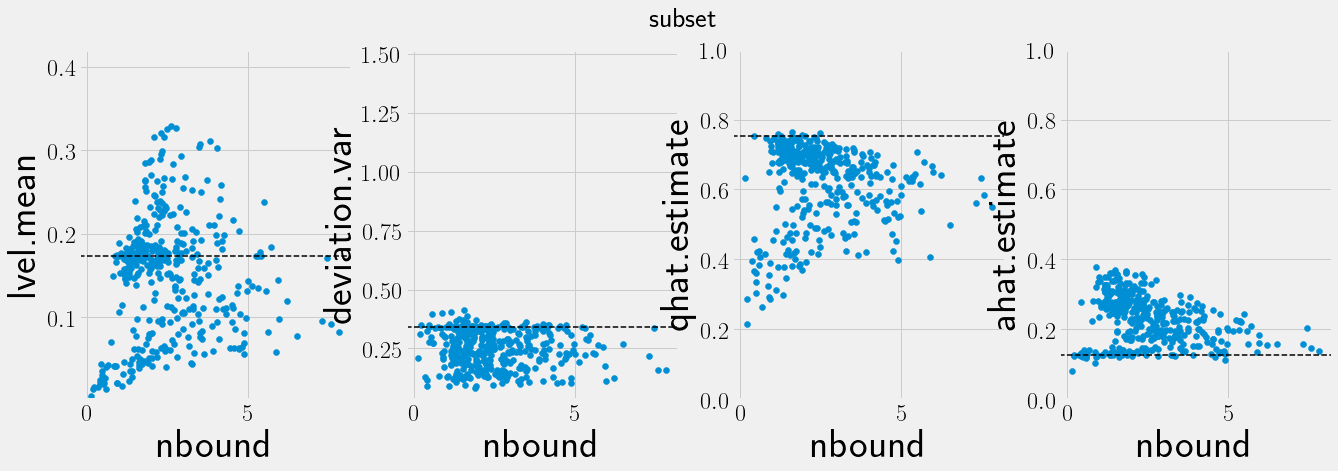

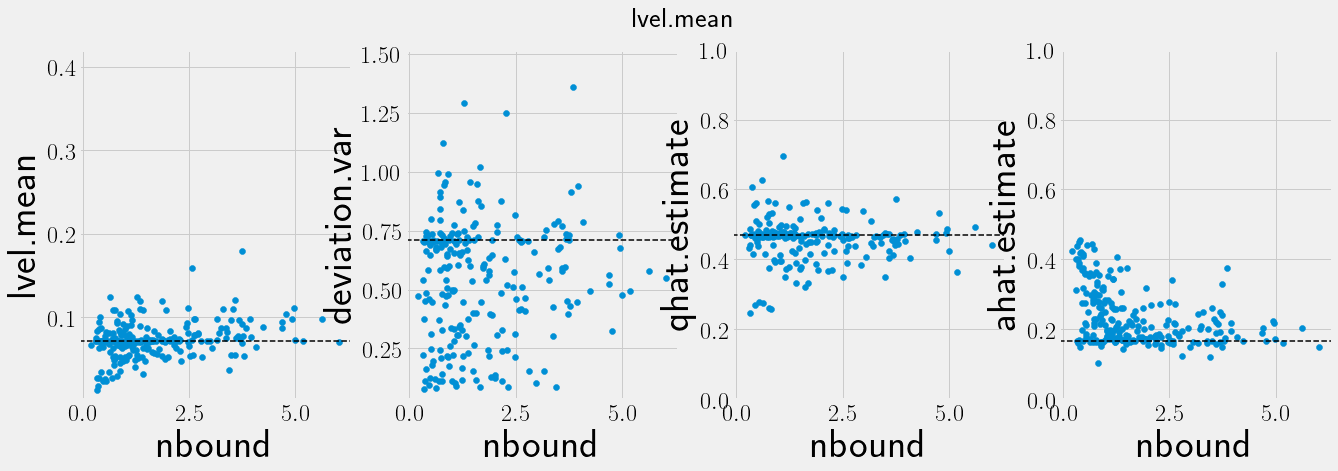

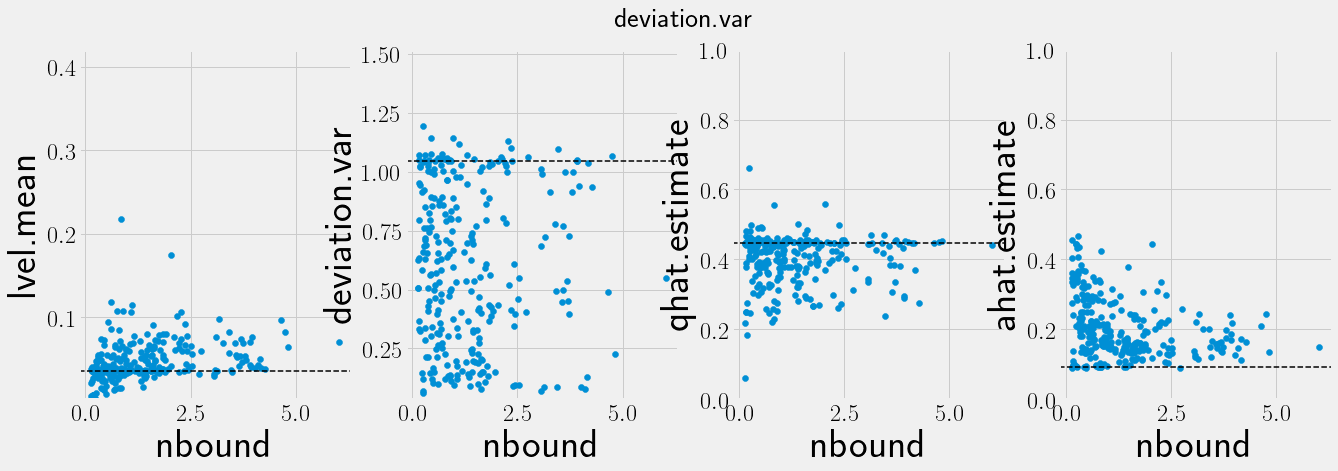

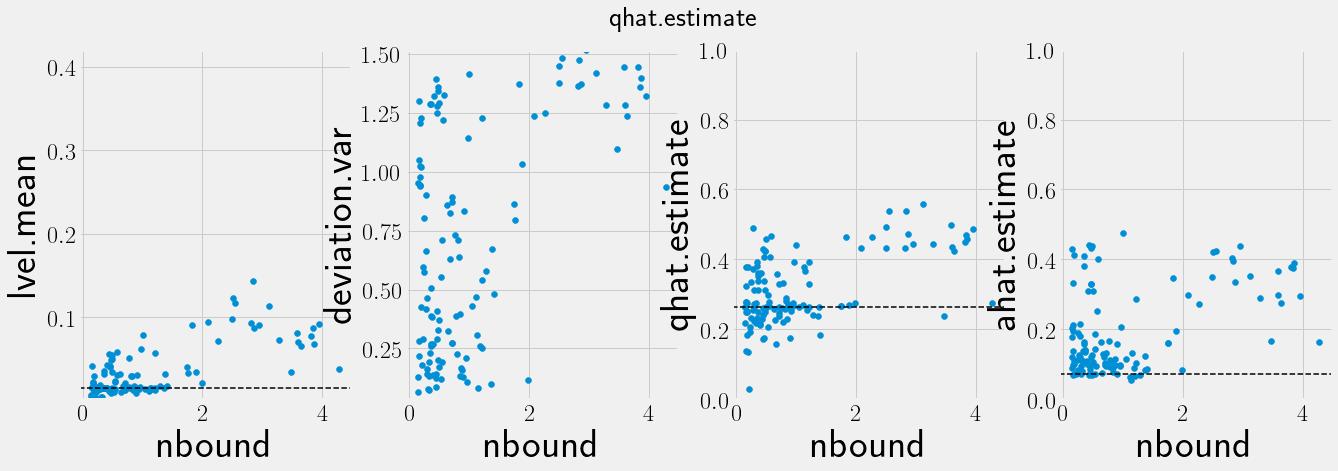

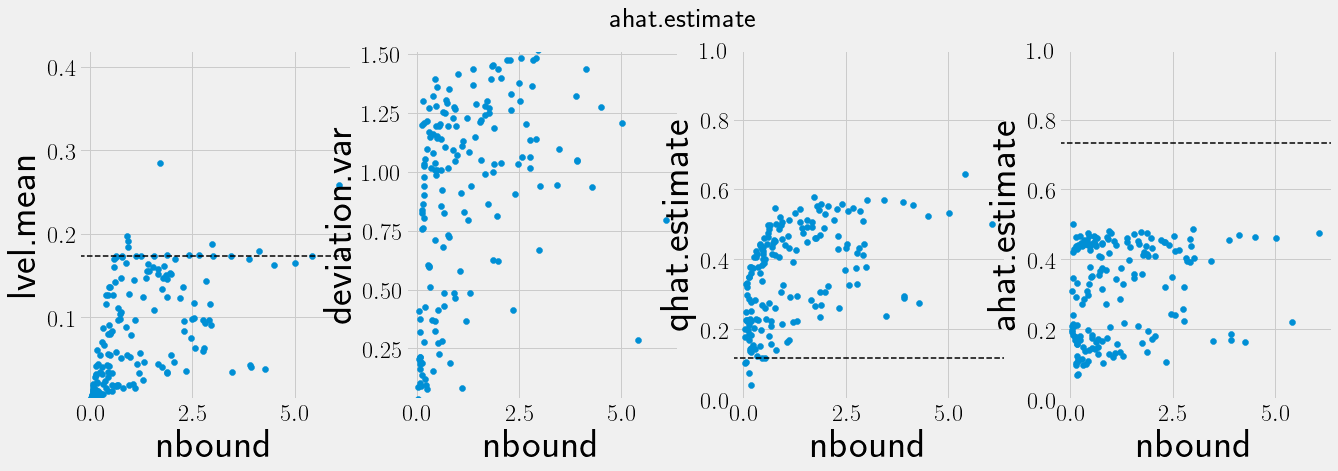

In [68]:
# pareto 

# Fairly fast for many datapoints, less fast for many costs, somewhat readable
# https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python
objectives = ['lvel.mean', 'deviation.var', 'qhat.estimate', 'ahat.estimate']

# convert Y to numpy array
N_samples = len(lookup[0])
Yarr = np.empty((N_samples,len(objectives)))
for i, name in enumerate(objectives):
    Yarr[:,i] = Y[name]

def pareto_scatter(xbasis, Y, objectives, refdata):
    candidate_point = np.array([refdata[name] for name in objectives])
    print('candidate point', candidate_point)

    # do pareto analysis
    Ycost = np.abs(Yarr - candidate_point)
    efficient = twutils.is_pareto_efficient_simple(Ycost)

    # and we'll replot them
    Yefficient = {name: Y[name][efficient] for name in objectives}
    nbound_efficient = Ynbound[efficient]
    fig, axes = plot_nbound_scatter(nbound_efficient, Yefficient, objectives, 
        total_bounds, refdata=refdata)
    return fig, axes

print("pareto sets ")
refdata = df
for i, subset in enumerate(refdata.keys()):
    rdata = df.iloc[i]

    if subset is "walking":
        continue # walking data needs walking simulation
    fig, axes = pareto_scatter(Ynbound, Y, objectives, rdata)
    fig.suptitle(subset, fontsize=28)


In [69]:
# linear combined metric
objectives = ['lvel.mean', 'deviation.var', 'qhat.estimate', 'ahat.estimate']

def summarise_objectives(Ydata):
    print("summary")
    limtable = []
    for name, v in Ydata.items():
        valid = v[~np.isnan(v)]
        lims = valid.min(), valid.max()
        limtable.append([name, *lims])
    header = ['objective', 'sample min', 'sample max']
    print(tabulate(limtable, header))
    print()

summarise_objectives(Y)

summary
objective                   sample min    sample max
------------------------  ------------  ------------
lvel.mean                   0.00192502      0.420543
deviation.var               0.0337051       1.51829
qhat.estimate               0.0119778       0.772191
ahat.estimate               0.0448946       0.502574
nbound.mean                 0.0316484       8.70775
bound_pili_participation    0.0602178       0.552562



In [70]:
# note I used this transform before I knew it was standard to normalise

def normal_transform(arr): 
    # return a function that operates on numpy arrays or single values
    valid = arr[~np.isnan(arr)]
    delta = valid.max() -  valid.min()
    vmin = valid.min()
    def transform(arr):
        # if arr[i] is nan then it will be propagated
        return (arr - vmin)/delta
    return transform

# linear combined metric = "lcm"
def linear_combined_metric(Ydata, objectives, factors=None):
    if not factors:
        n = len(objectives)
        factors = np.full(n,1.0/n)
    N = next(iter(Ydata.values())).size
    metric = np.zeros(N)
    for x, name in zip(factors, objectives):
        metric += x * Ydata[name] 	
    return metric


def optimal_sort(Y, objectives, refdata):
    # what is the variability in each metric ?
    _transform = {name : normal_transform(Y[name]) for name in objectives}
    Ynorm = {name : _transform[name](Y[name]) for name in objectives}

    # metric should be normalized?

    equalobjective = linear_combined_metric(Ynorm, objectives)

    # apply same transformation to candidate data

    ref_norm = {name: _transform[name](refdata[name]) for name in objectives}
    candidate_metric = linear_combined_metric(ref_norm, objectives)

    # finally sort the samples 
    var = np.abs(equalobjective - candidate_metric)
    sortidx =  np.argsort(var)
    return var, sortidx

var, sortidx = optimal_sort(Y, objectives, Ycandidate)

parameters = np.stack(lookup[1][uid] for uid in lookup[0])

if verbose:
    # print the top N parameter sets
    N = 10
    for idx in sortidx[:N]:
        print('{:.06f}, {}'.format(var[idx], parameters[idx]))


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [71]:
# construct numpy structured array containing sorted parameter sets
header = ['uid', 'score', *problem['names'], 'nbound.mean', *objectives]
types = ['U10', 'f8', *(['f8']*problem['num_vars']), 'f8', *(['f8']*len(objectives))]
dtype = {'names': header, 'formats': types}
table = np.empty(len(lookup[0]), dtype=dtype)
table['uid'] = np.array(lookup[0],dtype=types[0])
table['score'] = np.array(var)
table['nbound.mean'] = np.array(Ynbound)
for i, name in enumerate(problem['names']):
    table[name] = parameters[:,i]
for name in objectives:
    table[name] = Y[name]
sorted_file = join(notename, 'candidate_sorted_samples.npy')
print('writing to ', sorted_file)
struct_form = ['%s', *(['%9.6f']*(len(header)-1))]
table = np.sort(table, order=['score'])

# and save to file
np.savetxt(sorted_file, table, fmt=struct_form, header=' '.join(header))


writing to  notebook/candidate_sorted_samples.npy


In [72]:
refdata

,subset,lvel.mean,deviation.var,qhat.estimate,ahat.estimate
0,candidate,0.173882,0.340840,0.752234,0.126103
1,top,0.072232,0.708642,0.470209,0.165958
2,half,0.036487,1.044969,0.447158,0.092109
3,median,0.015663,1.599534,0.263178,0.073962
4,walking,0.173724,2.652627,0.118843,0.731995


In [73]:
refdata

,subset,lvel.mean,deviation.var,qhat.estimate,ahat.estimate
0,candidate,0.173882,0.340840,0.752234,0.126103
1,top,0.072232,0.708642,0.470209,0.165958
2,half,0.036487,1.044969,0.447158,0.092109
3,median,0.015663,1.599534,0.263178,0.073962
4,walking,0.173724,2.652627,0.118843,0.731995


<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-74-6ae81fc10991>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if subset is "walking":


linear combination metric
first score 0.00000212, (N=200)-th score 0.00241025
first score 0.00003273, (N=200)-th score 0.00611269
first score 0.00010081, (N=200)-th score 0.00712107
first score 0.00010960, (N=200)-th score 0.03421371


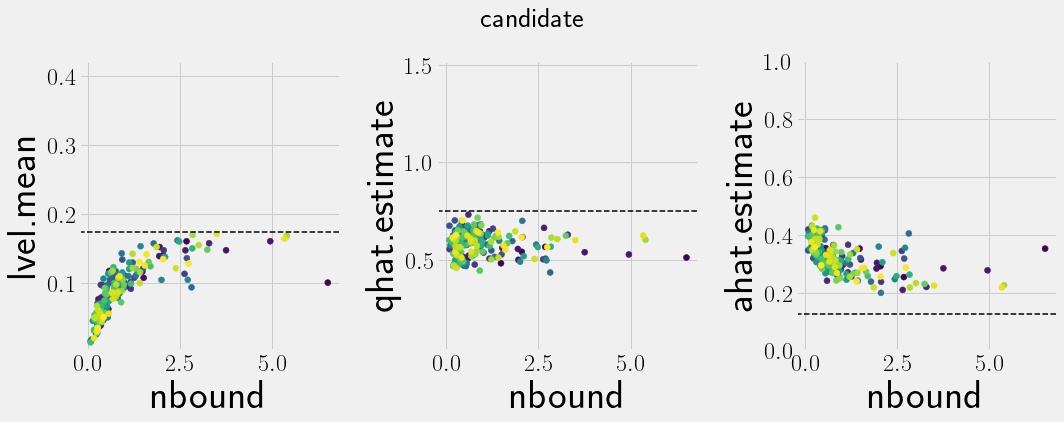

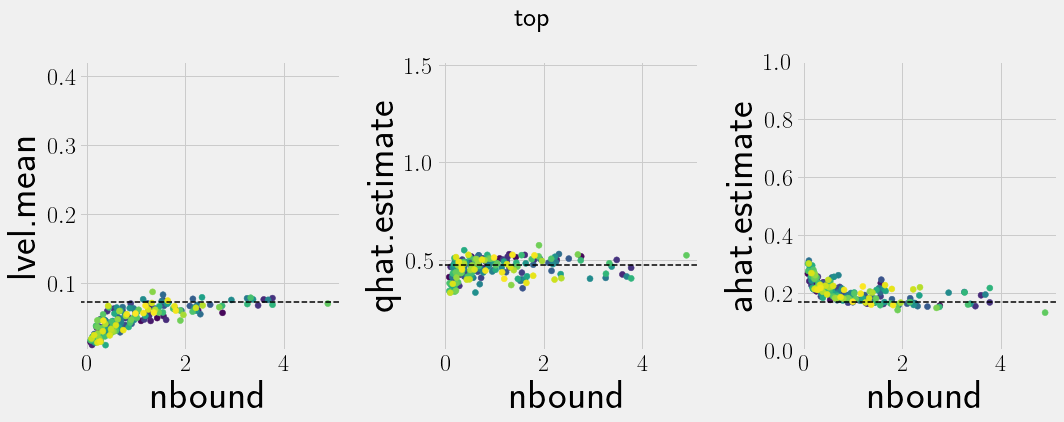

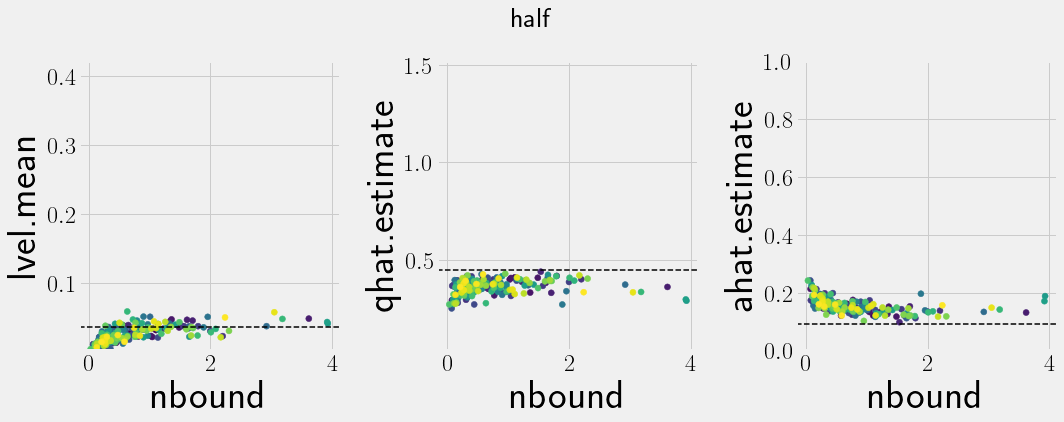

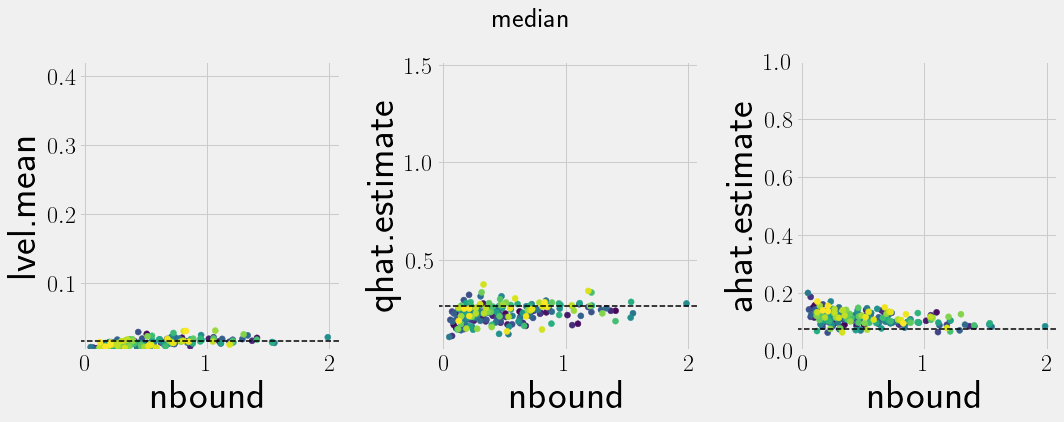

In [74]:
# scatter plot the first N points
print("linear combination metric")
def scatter_optimal(xbasis, Y, var, sortidx, **settings):
    N = 200
    scatteridx = sortidx[:N]
    print("first score {:.8f}, (N={:d})-th score {:.8f}".format(
        var[sortidx[0]], N, var[sortidx[N-1]]))
    nbound_metric = xbasis[scatteridx]
    Ymetric = {name : Y[name][scatteridx] for name in objectives}
    color = var[sortidx[:N]]
    fig,  axes = plot_nbound_scatter(nbound_metric, Ymetric, objectives, total_bounds, 
        color=color, refdata=settings["refdata"])
    fig.tight_layout()
    return fig, axes

# remove deviation.var since it will dominate the metric
objectives = ['lvel.mean', 'qhat.estimate', 'ahat.estimate']
for i, subset in enumerate(subsets):
    if subset is "walking":
        continue
    rdata = refdata.iloc[i]
    var, sortidx = optimal_sort(Y, objectives, rdata)
    settings = {"objectives":objectives, "refdata":rdata}
    fig, axes = scatter_optimal(Ynbound, Y, var, sortidx, **settings)
    fig.suptitle(subset, fontsize=28)
    fig.tight_layout()


In [75]:
# we see from sensitivity analysis that activty depends on pilivar and 
#  anchor_angle_smoothing_fraction.
# to project an objective onto an arbitrary set of model parameters we 
# need a smoothing kernel and a grid
# i.e. https://www.geodose.com/2018/01/creating-heatmap-in-python-from-scratch.html
# afaik matplotib doesn't have this feature built in 
# it may be time to use a more advanced library 
# https://seaborn.pydata.org/index.html
# we can't use kde_plot directly because what we actually want is 
# f(x) = \sum_i { activity * Kernel(x-x_i)} / \sum_i { Kernel(x-x_i)}
# but weighted kde is something like
# f(x) = \sum_i { weight_i * Kernel(x-x_i)} / \sum_i { weight_i }
import seaborn as sns
sns.set_theme()
# 
# active = ["k_resample", "anchor_angle_smoothing_fraction"]
active = ["pilivar", "anchor_angle_smoothing_fraction"]
active_index = [problem["names"].index(a) for a in active]
for i in active_index:
    print(problem["names"][i], problem["bounds"][i])

def project2d(lookup, active_index):
    l_order, l_uid = lookup
    xy = np.empty((len(l_order),2))
    for i, simkey in enumerate(l_order):
        params = l_uid[simkey]
        xy[i,:] = np.array([params[i] for i in active_index])
    return xy

xy = project2d(lookup, active_index)

activity = Y["ahat.estimate"]
Kernel = plotutils.KernelEstimator(xy, activity)

print("default bandwidth", Kernel.bw)
Kernel.set_bandwidth(Kernel.bw/2.0)
print("set bandwidth", Kernel.bw)


pilivar [1.0, 20.0]
anchor_angle_smoothing_fraction [0.125, 1.0]
default bandwidth 0.18075500659987095
set bandwidth 0.09037750329993548


In [76]:
# 
# plot the projection of data in lookup/objective onto pair of dimensions
# specified by active_index
def frame_active(lookup, active_index, objective):
    # should take problem as argument
    gridshape = (21,21)
    xy = project2d(lookup, active_index)
    Kernel = plotutils.KernelEstimator(xy, objective)
    # half the optimal bandwidth 
    Kernel.set_bandwidth(Kernel.bw/2.0)
    an, bn = gridshape
    a_i, b_i = active_index
    axn, axm = problem["bounds"][a_i]
    bxn, bxm = problem["bounds"][b_i] 
    a_edges = np.linspace(axn,axm,an+1,True)
    b_edges = np.linspace(bxn,bxm,bn+1,True)
    a_space = a_edges[:-1] + np.diff(a_edges)/2
    b_space = b_edges[:-1] + np.diff(b_edges)/2
    X1, X2 = np.meshgrid(a_space, b_space)
    points = np.stack([X1,X2],axis=2).reshape(-1,2)
    # evaluate points
    smooth = Kernel.evaluate(points) 
    data = smooth.reshape(gridshape)
    pdata = pd.DataFrame(data, a_space, b_space)
    return pdata

pdata = frame_active(lookup, active_index, activity)


Text(0.5, 27.158758658935206, 'Width of Pili Distribution')

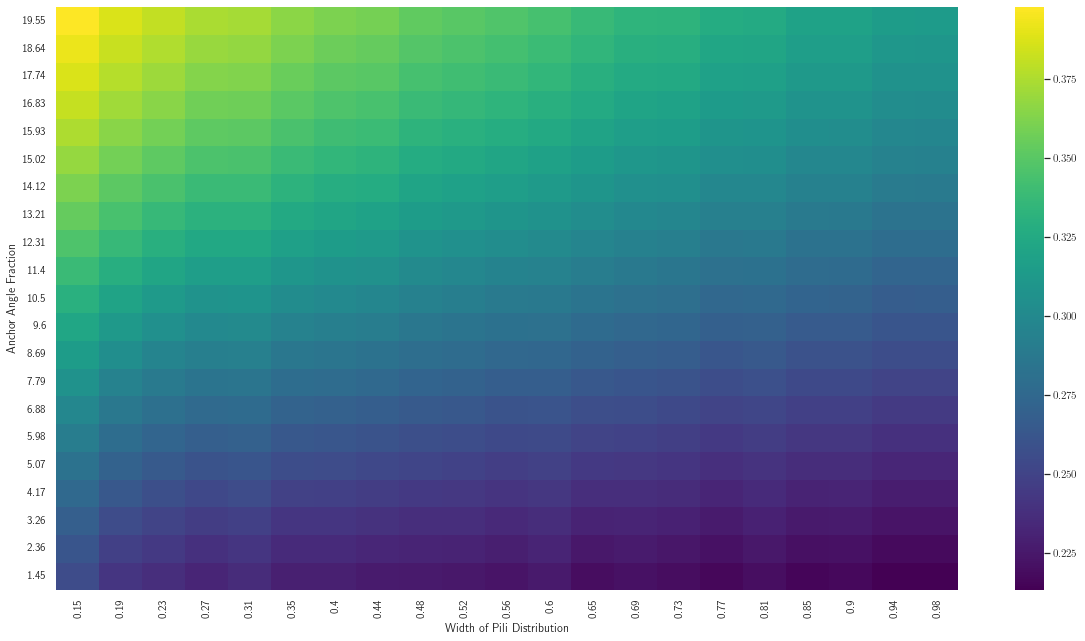

In [77]:
# use pandas dataframe to help plotting
palette = sns.color_palette("viridis", as_cmap=True)
def sns_pairdata(ax, pdata, snskw={}):
    ax = sns.heatmap(pdata, 
        ax=ax,
        cmap=palette,
        **snskw
        )
    ax.invert_yaxis()
    return ax
ax = sns_pairdata(plt.gca(), pdata)
xlabel, ylabel = [txtdata.longnames.get(name) for name in active]
ax.set_xticklabels(pdata.columns.values.round(2))
ax.set_yticklabels(pdata.index.values.round(2))
ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)


In [78]:
# check the sample distribution 
if verbose:
    x,y =xy.T
    ax = sns.scatterplot(x, y, 
        hue=activity, 
        palette=palette
        )
    xlabel, ylabel = [txtdata.longnames.get(name) for name in active]
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)


In [79]:
# plot heatmap for all pairs of parameters
# hypothesis is that pilivar and anchor_
# will show gradients

# test single plot
blocksetting = {"cbar":False, 
    "xticklabels":[], "yticklabels":[]
    }
# trial these settings
# sns_pairdata(plt.gca(), pdata, snskw=blocksetting)

In [80]:
# this is as good data as any to recover the relationship between activity
# and pilivar/anchor_constraint
# First question. What is the range of activity seen in fj, simulation
df["ahat.estimate"]
activity = Y["ahat.estimate"]
activity.min(), activity.max()
# max and min activities are much different to that on the graph
# because of the smoothing bandwidth
# construct the parameter dataframe
_parlist = zip(problem["names"],  zip(*[lookup[1][_u] for _u in lookup[0]]))
_cols = {"activity": activity}
_cols.update({k:v for k, v in _parlist})
pardf = pd.DataFrame(_cols)
ahatdf = pardf.sort_values("activity")
ahatdf
# now what? project onto pilivar/anchor and do ABC?
# then scatter plot?
# TODO


,activity,k_ext_off,dwell_time,pilivar,anchor_angle_smoothing_fraction,k_spawn,k_resample
11728,0.044895,0.633594,2.738770,19.350586,0.125854,1.005371,9.727539
11493,0.046008,0.914844,0.883301,6.733398,0.148071,0.829590,8.813477
8691,0.049818,0.935156,1.464355,4.766602,0.153198,0.627441,4.506836
8869,0.056895,0.708594,2.636230,4.172852,0.125854,1.699707,9.288086
8046,0.057171,0.628906,1.249512,4.915039,0.158325,0.891113,9.499023
...,...,...,...,...,...,...,...
13989,0.476276,0.325781,2.772949,16.456055,0.990601,4.854980,8.602539
6691,0.478193,0.357813,0.758789,1.333984,0.998291,4.780273,8.892578
6685,0.480431,0.839063,0.758789,1.333984,0.998291,4.780273,8.892578
4026,0.487586,0.217188,2.916992,8.236328,0.947021,2.688477,6.888672


<ipython-input-81-e8f3ff328dd5>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


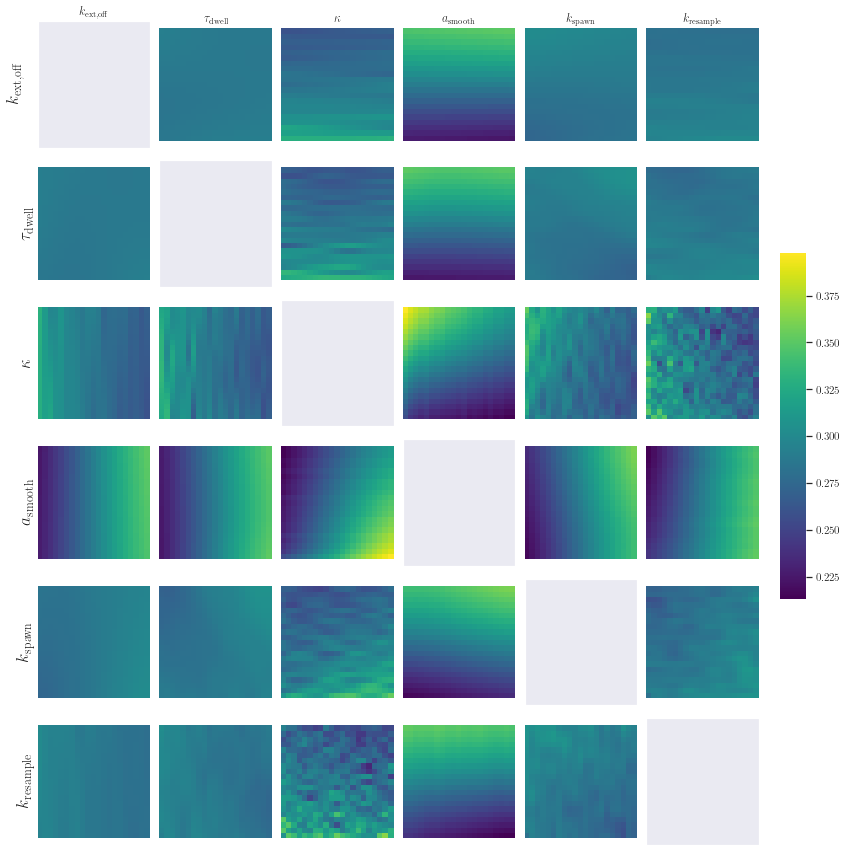

In [81]:
# plot projections onto all pairs of axes
n = len(problem["names"])
figl = n*2
fig , axes = plt.subplots(n, n, figsize=(figl,figl))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
pdatas = {}
for i in range(n):
    for j in range(n):
        # if i > j:
        #     fig.delaxes(axes[i,j])
        #     continue
        if i == j:
            ax = axes[i,j]
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.grid(False)
            continue
        active_pair = [i,j]
        # print("plotting for parameters ", [problem["names"][_k] for _k in active_pair])
        pdata = frame_active(lookup, active_pair, activity)
        pdatas[(i,j)] = pdata
# compute vmin/vmax accross all axes
vmin = min([pdata.to_numpy().min() for pdata in pdatas.values()])
vmax = max([pdata.to_numpy().max() for pdata in pdatas.values()])
blocksetting["vmin"] = vmin
blocksetting["vmax"] = vmax
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        pdata = pdatas[(i,j)]
        blockset = blocksetting.copy()
        if (i,j) == (0,1):
            blockset["cbar"] = True
            blockset["cbar_ax"] = cbar_ax
        ax = sns_pairdata(axes[i,j], pdata, snskw=blockset)
        ax.set_aspect('equal')

rows = [txtdata.shortnames.get(name) for name in problem["names"]]
cols = rows

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, size='x-large')

fig.tight_layout(rect=[0, 0, .9, 1])



 The visualisation of the activity metric is smoothly varying
 in pilivar, anchor_angle parameters.
 Activity is showing some less well ordered and less extreme variations
 for combinations with pilivar only and is essentially independent of
 dwell time, spawn_rate, k_resample as hoped.
 this is quite promising although the dependence on pilivar is an issue.
 It should be worth computing the velocity profile similarity parameter
 (even though this depends on the dataset we use)
 I want to verify my observation that the velocity profile  only compares
 well with experimental data when the anchor parameter is varied.

In [82]:
# sobol analysis with selective data onstraints 
# we want to use our sensitivity indices to break down the calibration problem
# into independent chunks but these indices may be sensitive to the arbitrary parameter limits
# in the sampling space

# Will our conclusions be robust if we use only part of that sampling space
# for example the part with nbound.mean in some range that we think is probable

#
objectives = ['lvel.mean', 'deviation.var', 'qhat.estimate', 'ahat.estimate', 'nbound.mean']

constraints = [
    ('nbound.mean', (0.5, 4.0))
]

# constraints = [
#     ('lvel.mean', (0.01, 0.3))
# ]

cname, lims = constraints[0]
print('constraint', cname, lims)
left, right = lims

calc_second_order = True
D = problem['num_vars'] 
step = 2 * D + 2 if calc_second_order else D + 2

# since A,B,AB,BA matrices are related, if one fails the condidition
# we have to remove all of them ?
# or else the condition is on A, B and if AB simulation exceeds the condition
# then its fine?
Ysim = np.array(lookup[0], dtype=object)
size = len(Ysim)

A = Ysim[0:size:step]
B = Ysim[(step - 1):size:step]

Aidx = np.array(range(0,size,step))
Bidx = np.array(range(step-1,size,step))

# loweridx = nbound < left 
# upperidx = nbound > right
A_mididx = np.logical_and(Ynbound[Aidx] < right, Ynbound[Aidx] > left)
B_mididx = np.logical_and(Ynbound[Bidx] < right, Ynbound[Bidx] > left)
mididx = np.logical_and(A_mididx, B_mididx)
midindex = np.argwhere(mididx).ravel()

print('No. samples remaining is {}'.format(
    np.sum(mididx)))

# now slice Y
N = 1024
constr = {}
for name in objectives:
    Yvalue = Y[name]
    segment = np.split(Yvalue, N)
    
    filtered = np.concatenate([segment[idx] for idx in midindex])
    constr[name] = sal.sobol.analyze(problem, filtered)

print("constrained sobol")
# tabulate_Si(constr, objectives)

dftable1, dftableT = sobol.format_sobol(problem, constr)

# func = lambda s: 'STRING' if isinstance(s, str) else 'FLOAT'
# table = dftable1.style.format({0: '{:.1f}', 2: func}, precision=4)

with open("/home/dan/usb_twitching/notes/sensitivity/tex/constr_table.tex", "w") as f:
    table = dftable1
    f.write(table.to_latex())

table


constraint nbound.mean (0.5, 4.0)
No. samples remaining is 504
constrained sobol


,parameter,lvel.mean,deviation.var,qhat.estimate,ahat.estimate,nbound.mean
0,k_ext_off,0.219773,-0.012140,0.128768,-0.006949,0.181070
1,dwell_time,0.009107,0.026001,0.009797,-0.006116,0.216954
2,pilivar,0.000805,0.758495,0.291100,0.038314,0.004155
3,anchor_angle_smoothing_fraction,0.451553,0.115130,0.597760,0.929253,-0.005085
4,k_spawn,0.255310,0.006965,0.003564,-0.001779,0.344015
5,k_resample,0.008577,-0.008734,0.013846,-0.006325,0.003187


In [83]:
# Sobol walking dataset
sobol_walking_dir = "/home/dan/usb_twitching/run/5bfc8b9/cluster/sobol_walking"

walking_lookup = sobol.read_lookup(sobol_walking_dir)
walking_problem = sobol.read_problem(sobol_walking_dir)
twutils.print_dict(walking_problem)


{
	"num_vars": 5,
	"names": [
		"k_ext_off",
		"dwell_time",
		"pilivar",
		"anchor_angle_smoothing_fraction",
		"k_spawn"
	],
	"bounds": [
		[
			0.2,
			1.0
		],
		[
			0.5,
			3.0
		],
		[
			1.0,
			20.0
		],
		[
			0.125,
			1.0
		],
		[
			0.1,
			5.0
		]
	]
}


In [84]:
# first job is to check that the simulation and analysis actually ran
def check_exists(lookup, simdir):
    stats_mask = np.array([os.path.exists(join(simdir, udir, "local.json")) for udir in lookup[0]])
    num, denom = np.count_nonzero(stats_mask), len(lookup[0])
    print('ran samples {}/{} ({:.1f}%)'.format(num, denom, 100*float(num)/denom))
check_exists(walking_lookup, sobol_walking_dir)

# load summary statistics 
objectives = ['lvel.mean', 'deviation.var', 'qhat.estimate', 'ahat.estimate']
_extra = ['nbound.mean', 'ntaut.mean', 'bound_pili_participation']
objectives.extend(_extra)
Yw = sobol.collect(objectives, targetdir=sobol_walking_dir, alldata=False)
missing = sobol.check_missing(walking_lookup, Yw)
print("missing: ", missing)

ran samples 7168/7168 (100.0%)
missing:  [['lvel.mean', 2, array([1029, 3231])], ['deviation.var', 2, array([1029, 3231])], ['qhat.estimate', 2, array([1029, 3231])], ['ahat.estimate', 2, array([1029, 3231])], ['nbound.mean', 0, array([], dtype=int64)], ['ntaut.mean', 0, array([], dtype=int64)], ['bound_pili_participation', 0, array([], dtype=int64)]]


In [85]:
second_order = False
nans = missing[0][2]
mask = sobol.filter_missing(walking_problem, walking_lookup, nans, 
    calc_second_order=second_order)
for k, arr in Yw.items():
    Yw[k] = arr[mask]


In [86]:
second_order = False
Sw = sobol.compute_sobol(walking_problem, Yw, second_order=second_order)
dftable1, dftableT = sobol.format_sobol(walking_problem, Sw)

display(HTML(dftable1.to_html()))
display(HTML(dftableT.to_html()))

df_write_latex(dftableT, "/home/dan/usb_twitching/notes/sensitivity/tex/walking_sobol.tex")


,parameter,lvel.mean,deviation.var,qhat.estimate,ahat.estimate,nbound.mean,ntaut.mean,bound_pili_participation
0,k_ext_off,-0.000069,0.009567,-0.005370,-0.013975,-0.000662,-0.000657,0.064802
1,dwell_time,0.361874,0.118110,0.041939,0.134169,0.299667,0.292361,0.005230
2,pilivar,0.236676,0.529399,0.595490,0.285554,0.019316,0.015567,0.860694
3,anchor_angle_smoothing_fraction,0.052462,0.012938,0.059182,0.297057,0.001079,0.000890,-0.003996
4,k_spawn,0.051196,0.304955,0.008967,0.034180,0.573473,0.598937,0.019767


,parameter,lvel.mean,deviation.var,qhat.estimate,ahat.estimate,nbound.mean,ntaut.mean,bound_pili_participation
0,k_ext_off,0.015282,0.028106,0.229738,0.044864,0.007043,0.008305,0.106413
1,dwell_time,0.591587,0.165410,0.267216,0.280307,0.399330,0.369038,0.018421
2,pilivar,0.351324,0.553866,0.783361,0.375452,0.033146,0.035526,0.887356
3,anchor_angle_smoothing_fraction,0.108793,0.071725,0.282663,0.410451,0.001005,0.002230,0.014873
4,k_spawn,0.259091,0.374905,0.298138,0.209527,0.677999,0.680494,0.051522


writing latex table to  /home/dan/usb_twitching/notes/sensitivity/tex/walking_sobol.tex


 As expected the anchor flexibility is not such a dominant parameter here
 but it is still important
 The table is less sparse i.e. parameters and objectives are
 more interconnected.
 nbount.mean is now dominated by dwell_time and k_spawn
 looks less well converged than crawling example
 but we need to solve the disk usage issue to check convergence

In [87]:
#################################################################################
# Principle component analysis
if verbose:
    # TODO plot optimal points in parameter space
    par = parameters[sortidx[:N]]
    # shape is = (N, 6), how to visualise this?
    # start by plotting the distribution in each dimension
    problem['names']
    nfeatures = len(problem['names'])
    fig, axes = plt.subplots(nfeatures,1,figsize=(6,5*nfeatures))
    plt.rcParams.update({'text.usetex': False})
    for i, name in enumerate(problem['names']):
        lname = txtdata.longnames.get(name)
        ax = axes[i]
        ax.hist(par[:,i], range=problem['bounds'][i])
        print(problem['bounds'][i])
        ax.set_xlim(problem['bounds'][i])
        ax.set_xlabel(lname)
    plt.tight_layout()
    # more or less as expected after looking at the results by eye there is no discernible pattern

# lets do principle component analysis?
# from sklearn.preprocessing import StandardScaler


In [88]:

if verbose: 
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import pandas as pd
    x = StandardScaler().fit_transform(par)
    pca = PCA(n_components=2)
    components = pca.fit_transform(x)
    # principal_df = pd.DataFrame(data =components 
    #              , columns = ['principal component 1', 'principal component 2'])

    ax= plt.gca()
    c1, c2 = components.T
    ax.scatter(c1, c2)
    ax.set_xlabel('principal component 1')
    ax.set_ylabel('principal component 2')
                
                


In [89]:
#################################################################################
# experiments with clustering 
clustering = False
#################################################################################


In [90]:
if clustering:

    # do clustering on the parameter space
    constraints = [
        ('nbound', (1.0, 3.0))
    ]

    cdata = constraints[0]
    cname, lims = cdata
    left, right = lims

    # nan values not included
    loweridx = nbound < left 
    upperidx = nbound > right
    mididx = np.logical_and(nbound < right, nbound > left)

    xuid_lower = xuid[loweridx]
    xuid_upper = xuid[upperidx]
    xuid_mid = xuid[mididx]
    print('No. samples {} < {} is {}'.format(
        cname, left, xuid_lower.size))
    print('No. samples {} > {} is {}'.format(
        cname, right, xuid_upper.size))
    print('No. samples {} remaining is {}'.format(
        cname, xuid_mid.size))

    # %% [markdown]
    # we note that there are no samples with nbound.mean > 5.0
    # despite k_spawn as high as 5.0
    # should increase the k_spawn upper limit


In [91]:
if clustering:
    # clustering on nbound lower and mid samples
    # the sampling dictionary {uid : [parameters]}
    print(problem['names'])
    sampling = lookup[1] 

    # clustering input array should have shape (n_samples, n_dimensions)
    X = np.stack([sampling[uid] for uid in xuid_mid])
    print("input size ", X.shape)

    print("start clustering ...")
    Z = heirarchy.linkage(X, 'ward')
    print("finished.")

    # c, coph_dists = heirarchy.cophenet(Z, pdist(X))
    # print("cophenetic correletion coefficient ", c)

    print("start dendrogram ...")
    start_time = time.time()
    # calculate full dendrogram
    plt.figure(figsize=(25, 10))
    # plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    heirarchy.dendrogram(
        Z,
        no_labels=True
        # leaf_rotation=90.,  # rotates the x axis labels
        # leaf_font_size=8.,  # font size for the x axis labels
    )
    plt.show()
    print("finished.")


In [92]:
if clustering:
    root = heirarchy.to_tree(Z)
    # two clusters
    print('left cluster count', root.get_left().count)
    print('right cluster count', root.get_right().count)
    print(Z.shape)
    print(Z[-1])
    print(Z[3011-Z.shape[0]-1])

    def get_leaves(node):
        stack = []
        discovered = set()
        stack.append(node)
        idlist = []
        while stack:
            node = stack.pop(-1)
            if node.id not in discovered:
                discovered.add(node.id)
                if node.is_leaf():
                    idlist.append(node.id)
                else:
                    children = [node.get_left(), node.get_right()]
                    for child in children:
                        stack.append(child)
        return np.array(idlist, dtype=int)

    l_cluster_idx = get_leaves(root.get_left())
    r_cluster_idx = get_leaves(root.get_right())

    # l_cluster = xuid_mid[l_cluster_idx]
    # r_cluster = xuid_mid[r_cluster_idx]

    # X is the input to the linkage matrix
    l_cluster = X[l_cluster_idx]
    r_cluster = X[r_cluster_idx]

    def summarise_cluster(cluster):
        print("limits") 
        limtable = []
        for d in range(cluster.shape[1]):
            varname = problem['names'][d] 
            lims = np.min(cluster[:,d]), np.max(cluster[:,d])
            limtable.append([varname, *lims, *problem['bounds'][d]])
        header = ['parameter', 'min', 'max', 'sample min', 'sample max']
        print(tabulate(limtable, header))
        # compute cluster mean
        center = np.mean(cluster,axis=0)
        print("centered at ", center)

    print('l_cluster')
    summarise_cluster(l_cluster)
    print()


    print('r_cluster')
    summarise_cluster(r_cluster)
    print()


 these clusters don't seem all that different to me
 sure, one cluster has low k_ext_off, high pilivar
 and another has high k_ext_off, low pilivar
 but intuitively no reason why these clusters shouldn't be well connected

In [93]:
if clustering:
    # Compute the sensitivity of of the nbound parameter
    # (with the idea to choose two parameters on which to project our data)
    Ynbound_std = ldget(lambda ld: ld['nbound']['std_error'])
    mid_nbound = Ynbound[mididx]
    print('subset has {} samples'.format(mid_nbound.size))
    mid_nbound_std = Ynbound_std[mididx]
    print('max std_error', np.max(mid_nbound_std))

    d = problem['num_vars']
    mid_nbound = factor_cut(mid_nbound, 2*d+2)

    Snbound = sal.sobol.analyze(problem, mid_nbound)
    print(problem['names'])
    print(Snbound['S1'])
    print(Snbound['S1_conf'])
    print(Snbound['ST'])
    print(Snbound['ST_conf'])

